# Goal of this notebook

In `fit_synthetic_with_f_transform`, we fit synthetic data by transforming curves to "q-space", performing linear regression there, and then transofrming relevant q's back to curve space. Here, we will do the same thing with real data.

# 1. Relevant functions from the previous notebook

In [4]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs


from geomstats.geometry.discrete_curves import ElasticMetric
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import torch
import matplotlib.pyplot as plt
#load discrete curves and R2 manifolds
from geomstats.geometry.discrete_curves import DiscreteCurves, R2


def plot_full_compare_ft(geodesic,a,b):
    

    n_geodesics = 1
    n_times = len(geodesic)
    #print(n_times)
    n_points = len(geodesic[0])

    
    # this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
    elastic_metric = ElasticMetric(a, b, ambient_manifold=R2)  


    #q_tensor = elastic_metric.f_transform(geods_square_rect[0])
    q_tensor = elastic_metric.f_transform(geodesic)

    q=np.array(q_tensor)

    #reshape q into a compressed vector
    q_vector = q.reshape((n_times, -1))
    print(q_vector.shape)

    #create regression object
    regr = linear_model.LinearRegression()

    #Now, i need to create an array that only has the times
    q_times_1d = gs.arange(0, n_times, 1)
    q_times = np.reshape(q_times_1d,(n_times,1))

    regr.fit(q_times,q_vector)

    #compute estimated q predictions
    q_vector_predict=regr.predict(q_times)

    #first, we will have to de-compress the vector (turn it back into its original shape)
    q_array_predict = np.reshape(q_vector_predict,(n_times,n_points-1,2))

    #now, we will transform the array back into a tensor so that f_transoform_inverse will accept it
    q_tensor_predict= torch.from_numpy(q_array_predict)

    starting_point_array = gs.zeros((n_times, 2))

    predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)

    #first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
    #is the predicted geodesic.
    
    
    #For plotting reasons, we create a new array from the original geodesic, 
    #where the starting point is zero for each shape.
    recentered_geodesic = gs.zeros([n_times,n_points,2])
    
    for i_time in range(n_times):
        distance_x = geodesic[i_time,0,0]
        distance_y = geodesic[i_time,0,1]
        for i_point in range(n_points):
            recentered_geodesic[i_time,i_point,0]=geodesic[i_time,i_point,0]-distance_x
            recentered_geodesic[i_time,i_point,1]=geodesic[i_time,i_point,1]-distance_y
    
    

    ##geodesic_array= np.array([geods_square_rect[0],predicted_curves])
    geodesic_array= np.array([recentered_geodesic,predicted_curves])
    

    n_geodesics_plot=2
    #n_geodesics_plot=3
    fig, axes = plt.subplots(
        n_geodesics_plot+1, n_times, figsize=(20, 10), sharex=True, sharey=True
    )
    fig.suptitle("Elastic Metric: a= "+str(a)+", b= " +str(b)+": Comparison between synthetic and 'q-predicted' geodesics", fontsize=20)

    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(n_times):
            axes[i_geodesic, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
            
    #now, creating the third set of plots, where they are overlaid
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(n_times):
            axes[2, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
    
    plt.tight_layout()

In [5]:
def plot_full_compare_ft_split_set(geodesic,a,b):
    #import dyn.dyn.datasets.synthetic as synthetic
    
    #n_times is an int
    #geodesic is the geodesic you want analyzed. This should be a tensor of shape (n_times,n_points,2)
    #"2" because we are considering 2D curves, so the data should be a set of (x,y) points.
    #a and b are the elastic metric parameters.

    n_geodesics = 1
    n_times = len(geodesic)
    n_points = len(geodesic[0])

    #creating our synthetic dataset
    #geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    #    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
    #)

    # this is creating (aka "instantiating") an object elastic_metric of the class ElasticMetric
    elastic_metric = ElasticMetric(a, b, ambient_manifold=R2)  

    #selecting the first (and only) geodesic
    #geodesic = geods_square_rect[0]

    ##q_tensor = elastic_metric.f_transform(geods_circle_ell[0])
    q_tensor = elastic_metric.f_transform(geodesic)

    q=np.array(q_tensor)

    #reshape q into a compressed vector
    q_vector = q.reshape((n_times, -1))

    #create regression object
    regr = linear_model.LinearRegression()

    #Now, i need to create an array that only has the times
    q_times_1d = gs.arange(0, n_times, 1)

    half_n_times = int(n_times/2)

    #NEW HERE: splitting the dataset
    q_times_1d_train = q_times_1d[:half_n_times]
    q_times_1d_test = q_times_1d[half_n_times:]

    #splitting the vector dataset
    q_vector_train= q_vector[:half_n_times]
    q_vector_test = q_vector[half_n_times:]

    q_times_train = np.reshape(q_times_1d_train,(half_n_times,1))
    q_times_test = np.reshape(q_times_1d_test,(n_times-half_n_times,1))

    regr.fit(q_times_train,q_vector_train)

    #compute estimated q predictions
    q_vector_predict=regr.predict(q_times_test)

    q_array_predict = np.reshape(q_vector_predict,(n_times-half_n_times,n_points-1,2))

    #now, we will transform the array back into a tensor so that f_transoform_inverse will accept it

    q_tensor_predict= torch.from_numpy(q_array_predict)

    #do the transform
    starting_point_array = gs.zeros((n_times-half_n_times, 2))

    predicted_curves=elastic_metric.f_transform_inverse(q_tensor_predict,starting_point_array)

    #first, i will create a new array, where one of the geodesics is the original geodesic and the other geodesic
    #is the predicted geodesic. The third figure will show the two curves overlaid on each other.
    
    #This creates a new array from the original geodesic, where the starting point is zero for each shape.
    recentered_geodesic = gs.zeros([n_times,n_points,2])
    
    for i_time in range(n_times):
        distance_x = geodesic[i_time,0,0]
        distance_y = geodesic[i_time,0,1]
        for i_point in range(n_points):
            recentered_geodesic[i_time,i_point,0]=geodesic[i_time,i_point,0]-distance_x
            recentered_geodesic[i_time,i_point,1]=geodesic[i_time,i_point,1]-distance_y
    
    ##geodesic_array= np.array([geods_circle_ell[0,half_n_times:],predicted_curves])
    geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])

    n_geodesics_plot=2
    fig, axes = plt.subplots(
        n_geodesics_plot+1, n_times-half_n_times, figsize=(20,10), sharex=True, sharey=True
    )
    fig.suptitle("Elastic Metric: a= "+str(a)+", b= " +str(b)+": Comparison between synthetic and 'q-predicted' geodesics", fontsize=20)
    
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(n_times-half_n_times):
            axes[i_geodesic, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
            
        
            
    #now, creating the third set of plots, where they are overlaid
    for i_geodesic in range(n_geodesics_plot):
        curve = geodesic_array[i_geodesic]
        for i_time in range(n_times-half_n_times):
            axes[2, i_time].plot(
                curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
            )
            axes[i_geodesic, i_time].set_aspect("equal")
            
    plt.tight_layout()

# 2. Loading real data

## 2.1 Project specific imports

In [6]:
import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()

ModuleNotFoundError: No module named 'dyn.viz'

## 2.2 Loading trajectory of border cells

In [7]:
centers_traj, shapes_traj, imgs_traj, labels = experimental.load_trajectory_of_border_cells(n_sampling_points=60)


 Processing trajectory 1/16.
Converting 104438_MAX_9-7.tif into list of cell contours...

 Processing trajectory 2/16.
Converting 33623_MAX_9-2-1-28.tif into list of cell contours...
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).



 Processing trajectory 7/16.
Converting 59080_MAX_9-7.tif into list of cell contours...
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell cont

Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (

In the cell above: we load the trajectory of the centers, the shape trajectories, the image trajectories, etc. Shape traectories has all the shapes.

In [9]:
print(shapes_traj.shape)

torch.Size([16, 25, 60, 2])


## 2.3 Regression on trajectories

TODO: TEST FOR ALL OF THE TRAJECTORIES AND SEE IF ONE FOLLOWS A GEODESIC
-also, line up the final plot using the center of the shape instead of setting the initial point to be zero (first element of tuple is center of shape. center was computed in experimental.py)
-undo "recenter" because that is messing up the "movement" of the cell. also, it was already programmed to be centered (0,0) at the center of the cell.

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_7780/3086311501.py:81: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_7780/3086311501.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([recent

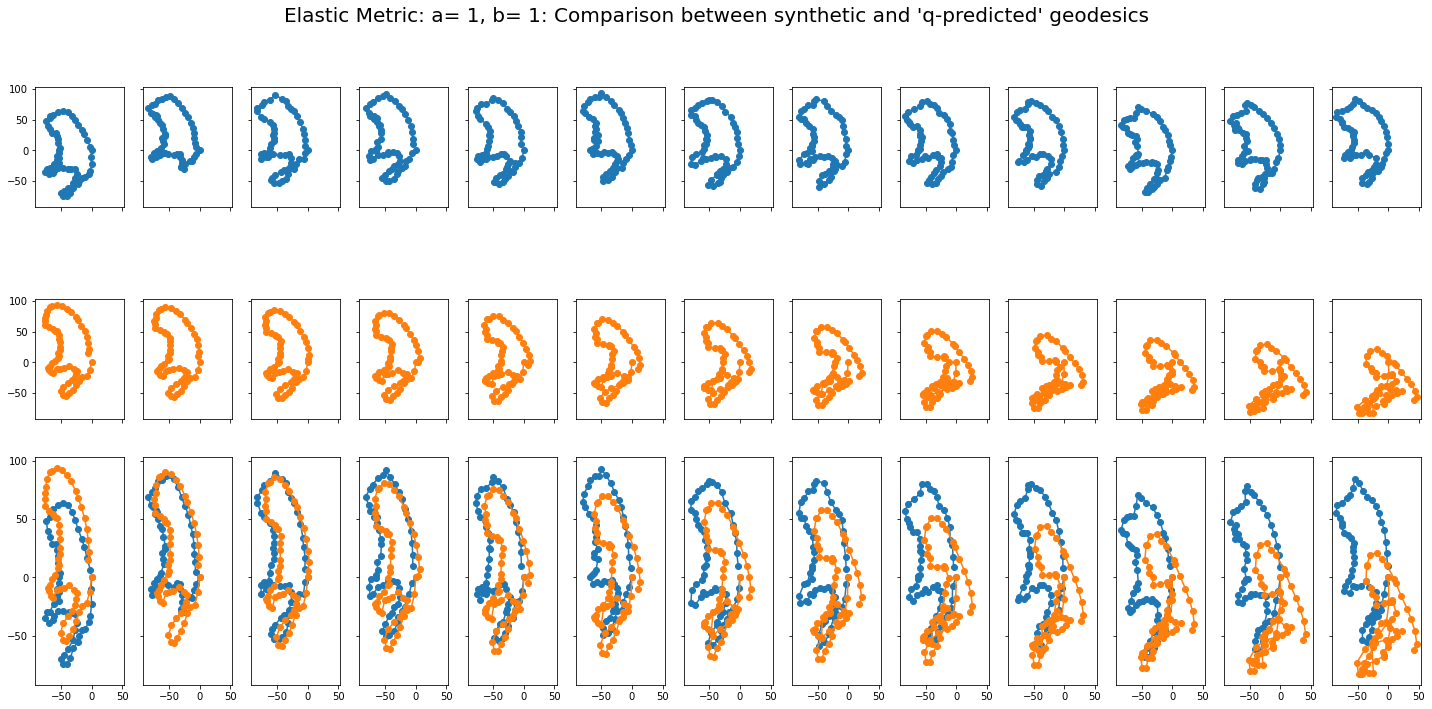

In [77]:
plot_full_compare_ft_split_set(shapes_traj[0],1,1)

(25, 118)


/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/2603114799.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic,predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/2603114799.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([recentered_geodesic

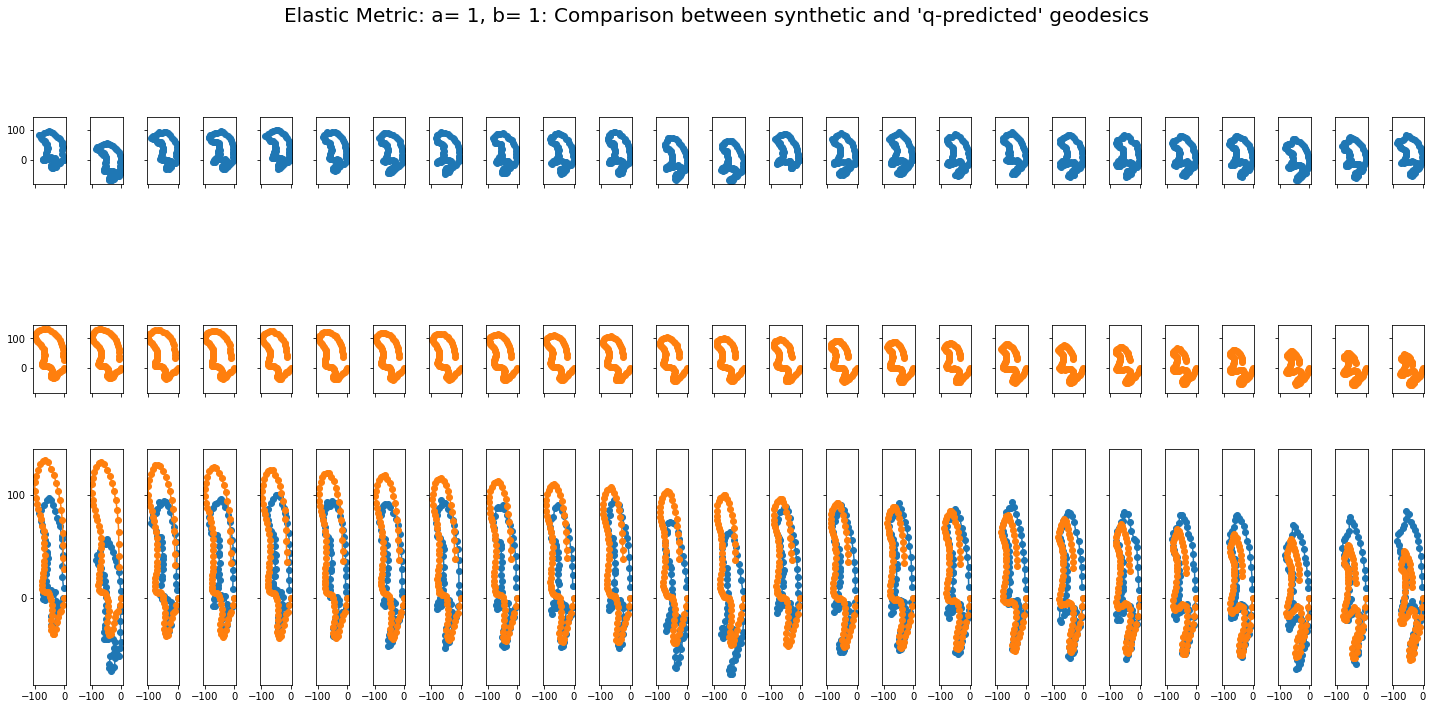

In [15]:
#only taking the first half because the second half has Nan, which is throwing errors.
plot_full_compare_ft(shapes_traj[0],1,1)

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_7780/1447053130.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic,predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_7780/1447053130.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([recentered_geodesic,p

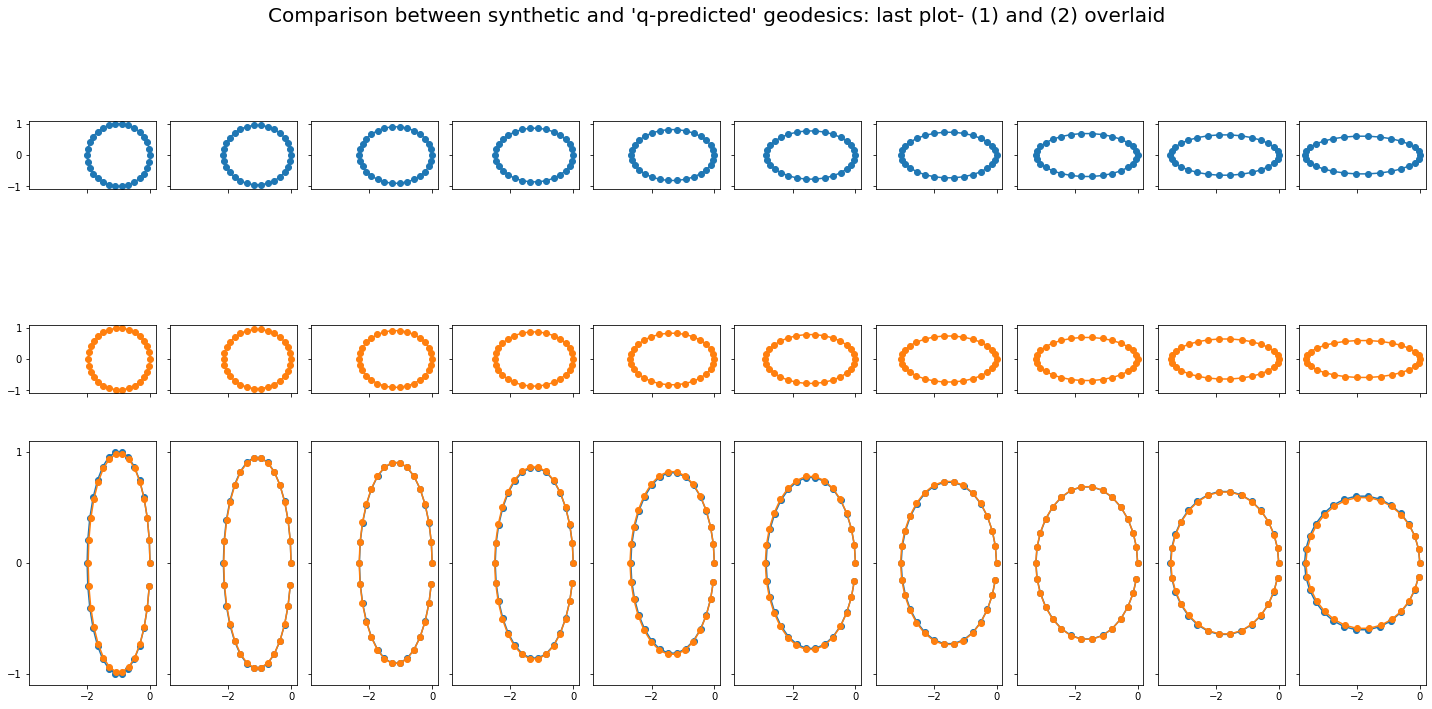

In [32]:
import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 1
n_times = 10
n_points = 30

#creating our synthetic dataset
geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

plot_full_compare_ft(geods_circle_ell[0],1,1)

## 2.4 Regression on trajectories with different a, b.

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([rece

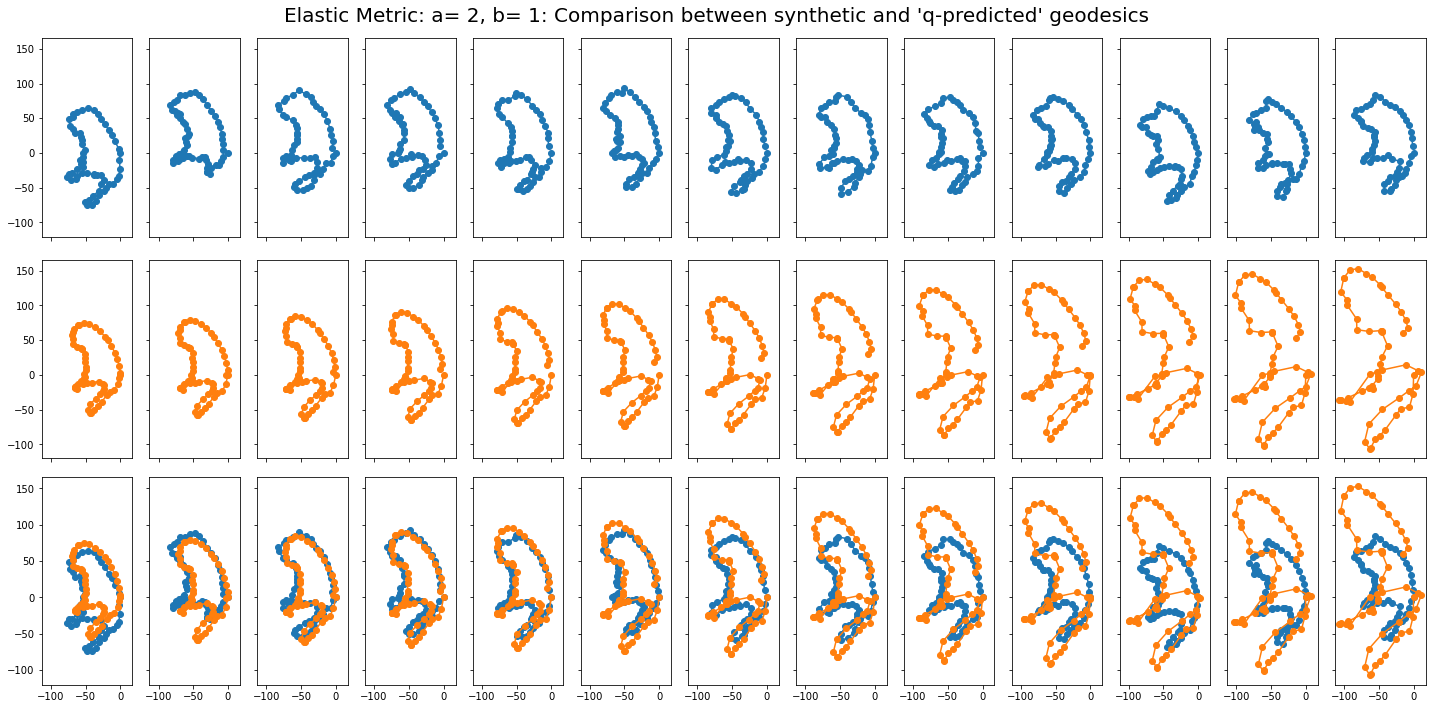

In [11]:
plot_full_compare_ft_split_set(shapes_traj[0],2,1)

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([rece

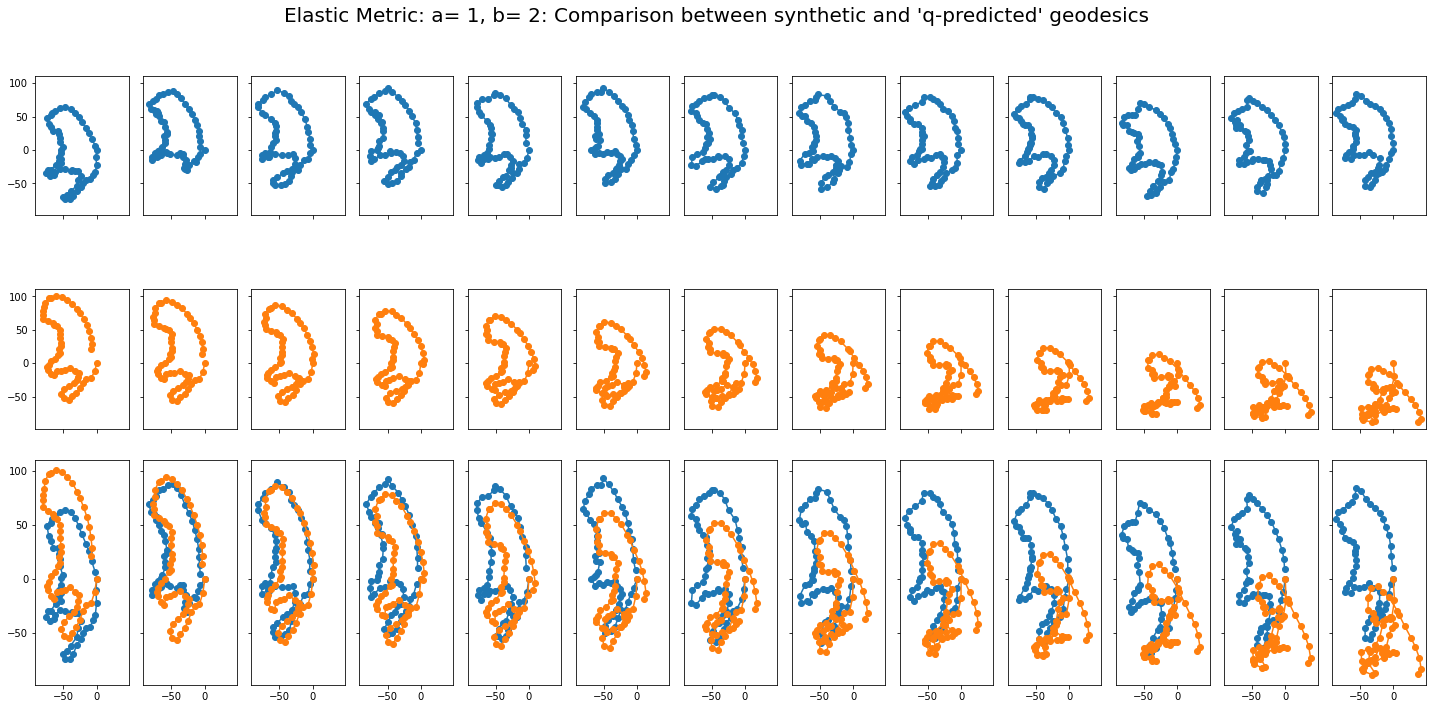

In [12]:
plot_full_compare_ft_split_set(shapes_traj[0],1,2)

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([rece

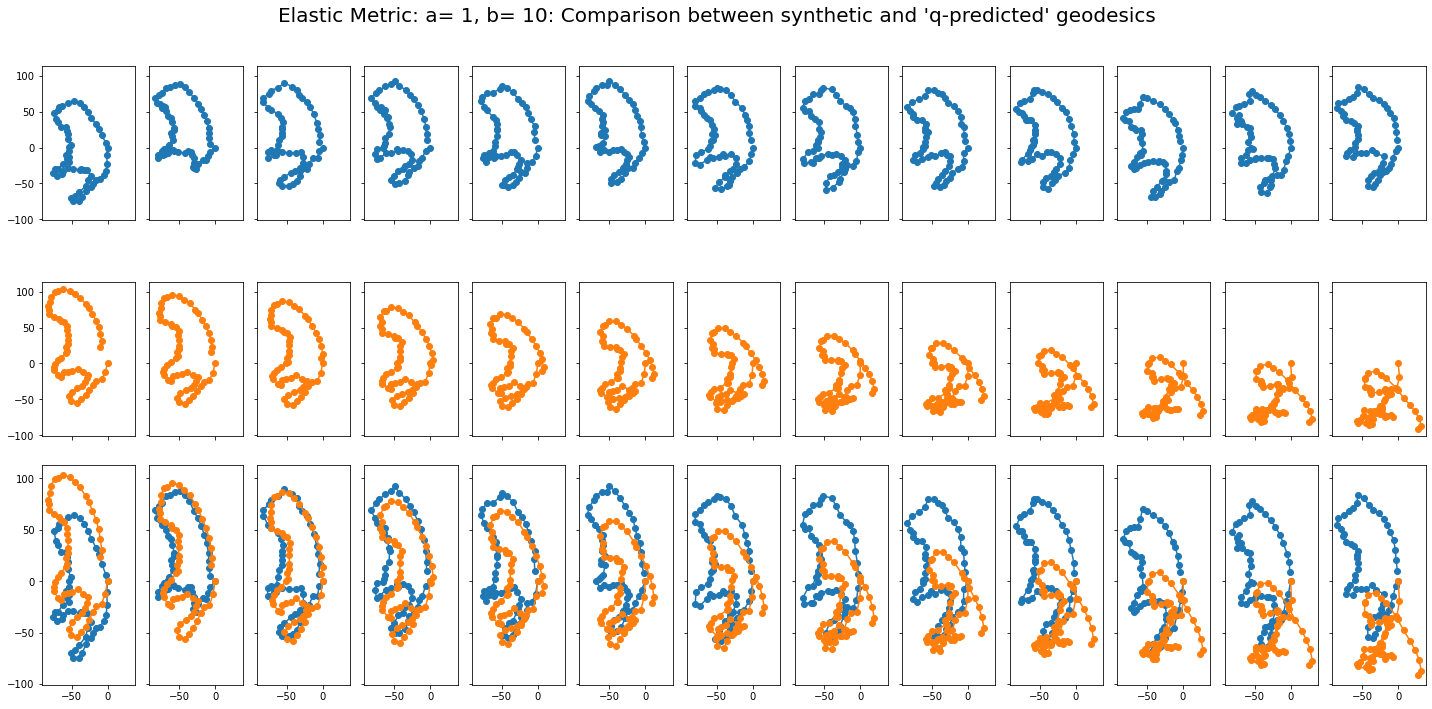

In [13]:
plot_full_compare_ft_split_set(shapes_traj[0],1,10)

/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([recentered_geodesic[half_n_times:],predicted_curves])
/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3086311501.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([rece

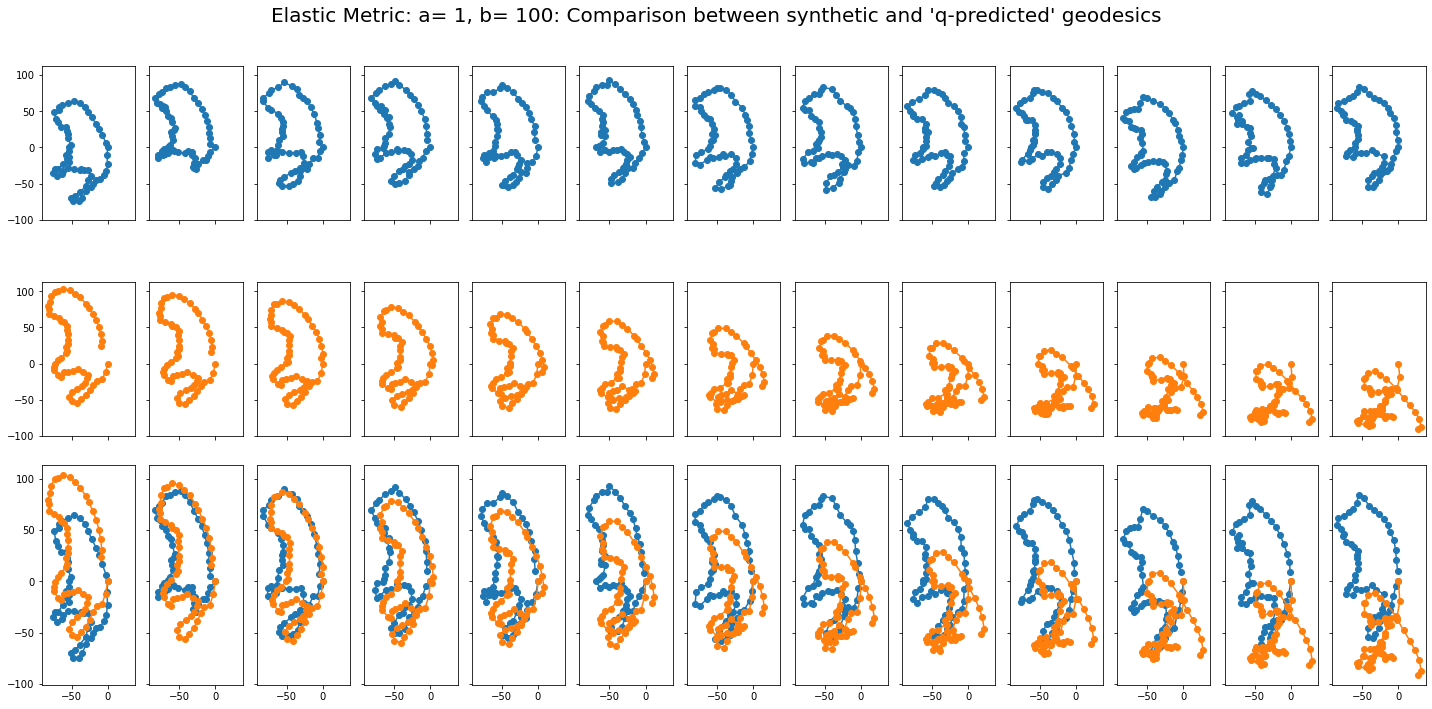

In [14]:
plot_full_compare_ft_split_set(shapes_traj[0],1,100)